<a href="https://colab.research.google.com/github/heejjj/Health_Bio_AI/blob/bio_colab/pj2_team4_0410.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#vgg16에 사용된 DATASET : https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

%matplotlib inline
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
import os
import tensorflow_hub as hub
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from keras.metrics import accuracy
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from numpy.random import seed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam

1.  yes와 no파일을 각각 불러오고 리사이즈하여 규격화하고 label처리를 한다.

2. 랜덤하게 train set와 test set을 8:2비율로 분리한다.

3. model을 세팅한다. 

In [ ]:
#파일 불러오기(yes)
data=[]
paths=[]
labels=[]
for r,d,f in os.walk("/content/drive/MyDrive/archive-6/brain_tumor_dataset/yes"):
    for file in f:
        if ".jpg" in file:
            paths.append(os.path.join(r,file))
for r,d,f in os.walk("/content/drive/MyDrive/archive-6/yes"):
    for file in f :
        if ".jpg" in file:
            paths.append(os.path.join(r,file))
for path in paths:
    img = Image.open(path)
    img = np.array(img)


for path in paths:
    img=Image.open(path)
    img=img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        labels.append(1)

In [ ]:
#파일 불러오기(no)
paths = []
for r, d, f in os.walk(r"/content/drive/MyDrive/archive-6/brain_tumor_dataset/no"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))
for r, d, f in os.walk(r"/content/drive/MyDrive/archive-6/no"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))


for path in paths:
    img=Image.open(path)
    img=img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        labels.append(0)
data = np.array(data)
data.shape

(278, 128, 128, 3)

In [ ]:
labels=np.array(labels)
labels=labels.reshape(278,1)
print('data shape is:', data.shape)
print('labels shape is:', labels.shape)

data shape is: (278, 128, 128, 3)
labels shape is: (278, 1)


In [ ]:
print(np.max(data))
print(np.min(data))

255
0


In [ ]:
data=data/255.00
print(np.max(data))
print(np.min(data))

1.0
0.0


In [ ]:
x_train,x_test, y_train,y_test= train_test_split(data,
                                                 labels,
                                                 test_size=0.2,             #traing 80% test 20%를 데이터셋으로활용.
                                                 shuffle = True,            #split 전 섞기
                                                 random_state = 8)          #데이터셋변환방지

In [ ]:
base_model=VGG16(include_top=False,weights='imagenet',input_shape=(128,128,3))

In [ ]:
model = keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.25), # 데이터셋이 적기때문에 과적합을 우려하여 노드를 독립적인확률(75%)로 활성화시켜학습.
    layers.Dense(units=256, activation="relu"), #units : 256 , activation : relu
    layers.BatchNormalization(),
    layers.Dense(units=1, activation="sigmoid") #0,1로 반환하기 위해 sigmoid사용
])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', #validation accuracy 를 정지 지표로사용
    min_delta = 0, #개선된 것으로 간주하기 위한 최소한의 변화량
    patience=5, #최적의 monitor 값을 기준으로 몇 번의 epoch을 진행할 지 정하는 값
    verbose=1, #만약 earlystopping되면 알림
    mode='max', #과적합이 일어났을 때validation accuracy가 떨어지는것을 상정하고 validatioin accuracy가 최대가 되어야한다 지정
)

In [ ]:
from keras.optimizers import SGD

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


model.compile(
    optimizer=SGD(learning_rate=0.0005),                #optimizer : SGD (ADAM보다 val_accuracy가 높게 나옴, ADAM과 NADAM사용시 validation과정에서 precision값이 너무 낮게 측정됨.)
    loss="binary_crossentropy",                         #loss : binary_crossentropy
    metrics=["accuracy", f1_m, precision_m, recall_m, tf.keras.metrics.AUC(name='AUC'), tf.keras.metrics.BinaryIoU(name='IoU')])  #metrics : accuracy
 
# fit the model
history = model.fit(x_train, y_train,
                    validation_split=0.2,               #validation_split : 0.2
                    callbacks=[callback], 
                    batch_size = 80,                    #batchsize : 32 or 64
                    epochs=24)                          #epochs : 12였으나 위에서 callback으로 EarlyStopping걸어서 자동으로 정지하기에 24로 지정했습니다


Epoch 1/24
3/3 [==============================] - 28s 4s/step - loss: 0.9154 - accuracy: 0.4915 - f1_m: 0.4677 - precision_m: 0.4752 - recall_m: 0.4694 - AUC: 0.4735 - IoU: 0.3247 - val_loss: 0.6232 - val_accuracy: 0.6000 - val_f1_m: 0.7500 - val_precision_m: 0.6000 - val_recall_m: 1.0000 - val_AUC: 0.7932 - val_IoU: 0.3000
Epoch 2/24
3/3 [==============================] - 1s 298ms/step - loss: 0.7591 - accuracy: 0.5141 - f1_m: 0.5508 - precision_m: 0.5212 - recall_m: 0.5878 - AUC: 0.5608 - IoU: 0.3459 - val_loss: 0.5899 - val_accuracy: 0.6444 - val_f1_m: 0.7714 - val_precision_m: 0.6279 - val_recall_m: 1.0000 - val_AUC: 0.8724 - val_IoU: 0.3695
Epoch 3/24
3/3 [==============================] - 1s 260ms/step - loss: 0.6739 - accuracy: 0.6780 - f1_m: 0.6150 - precision_m: 0.5765 - recall_m: 0.6613 - AUC: 0.6888 - IoU: 0.5119 - val_loss: 0.5613 - val_accuracy: 0.6889 - val_f1_m: 0.7941 - val_precision_m: 0.6585 - val_recall_m: 1.0000 - val_AUC: 0.8981 - val_IoU: 0.4404
Epoch 4/24
3/3 [==

In [ ]:
!pip install graphviz
!pip install pydot


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


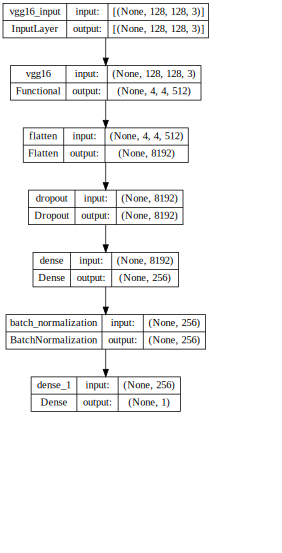

In [ ]:
#model시각화 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

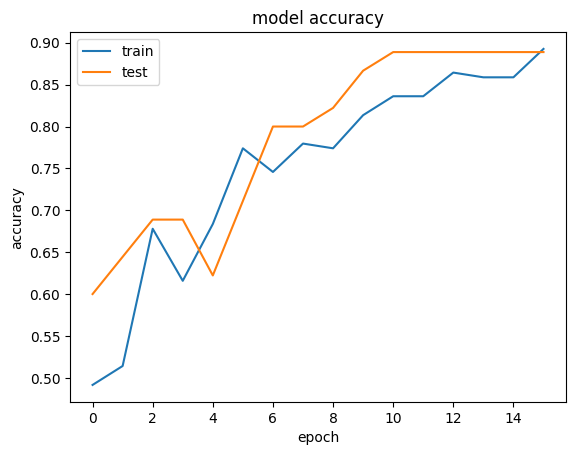

In [ ]:
#model결과 시각화
## accuracy, val_accuracy의 epoch에 따른 상승비교 그래프
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


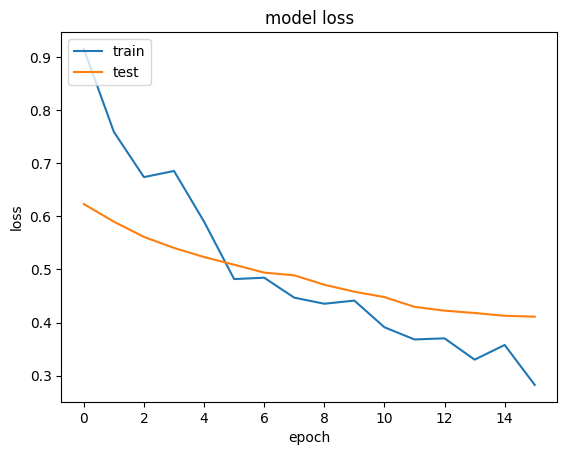

In [ ]:
## loss, val_loss의 epoch에 따른 감소비교 그래프
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

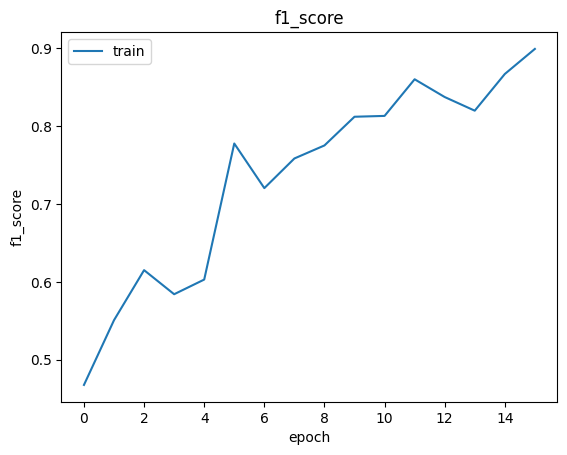

In [ ]:
#model결과 f1_score 시각화
plt.plot(history.history['f1_m'])
plt.title('f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

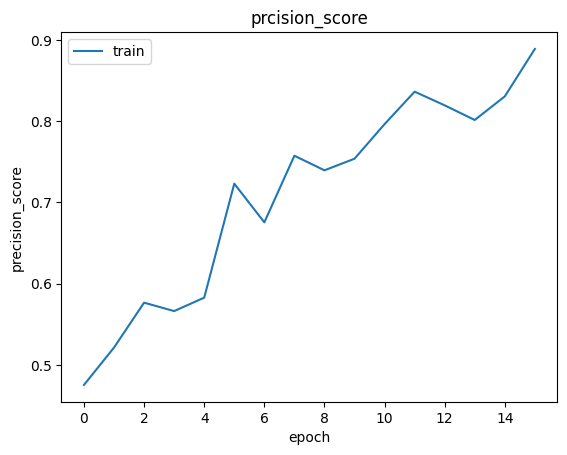

In [ ]:
#model결과 precision_score 시각화
plt.plot(history.history['precision_m'])
plt.title('prcision_score')
plt.ylabel('precision_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

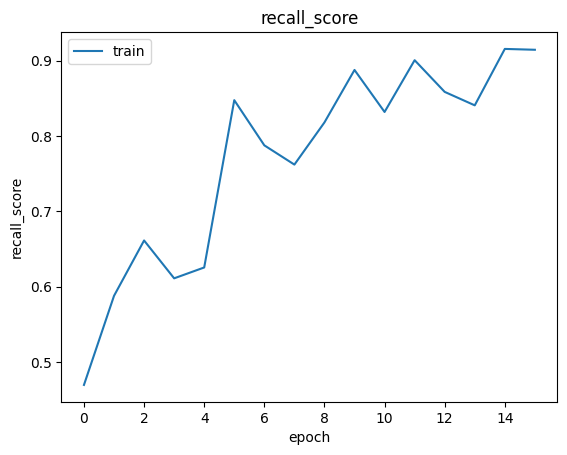

In [ ]:
#model결과 recall_score 시각화
plt.plot(history.history['recall_m'])
plt.title('recall_score')
plt.ylabel('recall_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

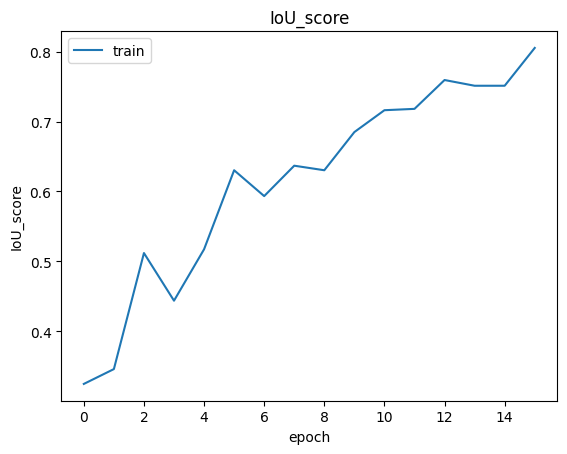

In [ ]:
#model결과 IoU_score 시각화
plt.plot(history.history['IoU'])
plt.title('IoU_score')
plt.ylabel('IoU_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# #model결과 시각화 모아보기
# %matplotlib inline
# import matplotlib.pyplot as plt

# fig, loss_ax = plt.subplots()

# acc_ax = loss_ax.twinx()

# loss_ax.plot(history.history['loss'], label='train loss')
# loss_ax.plot(history.history['val_loss'], label='val loss')

# acc_ax.plot(history.history['accuracy'], 'tab:olive', label='train acc')
# acc_ax.plot(history.history['val_accuracy'], 'tab:purple', label='val acc')

# loss_ax.set_xlabel('epoch')
# loss_ax.set_ylabel('loss')
# acc_ax.set_ylabel('accuray')

# loss_ax.legend(loc='upper left')
# acc_ax.legend(loc='lower left')

# plt.show()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                        

In [ ]:
cam_model = tf.keras.Model(model.input, outputs=(model.layers[-3].output, model.layers[-1].output))
cam_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16_input (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                             

In [ ]:
y_pred = model.predict(x_test)

2/2 [==============================] - 4s 1s/step


In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threstholds = roc_curve(y_test, model.predict(x_test))
roc_auc = auc(fpr, tpr)
print('AUROC : ', roc_auc) 

2/2 [==============================] - 0s 58ms/step
AUROC :  0.9652406417112298


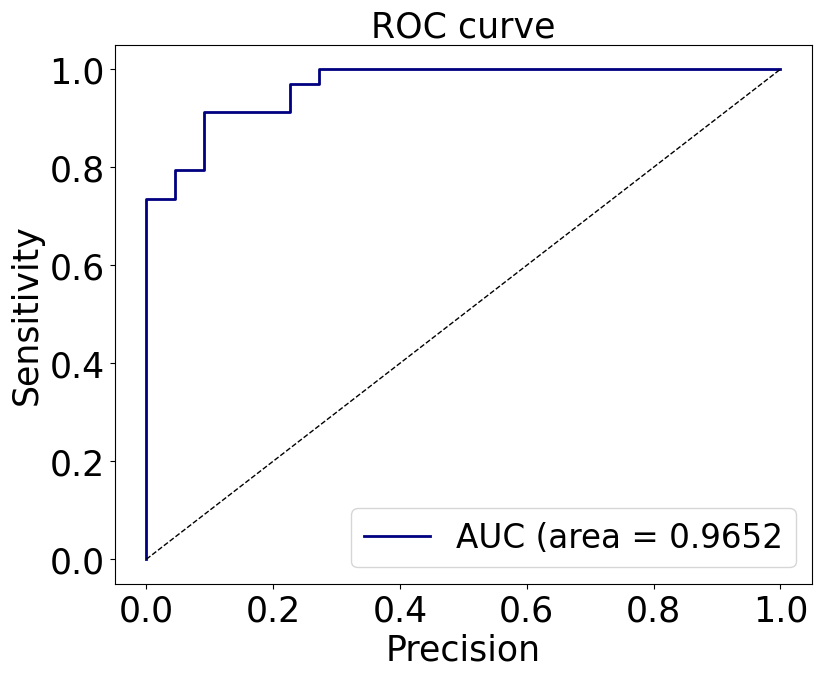

In [ ]:
plt.figure(figsize=[9,7])
plt.plot(fpr, tpr, color='navy', lw=2, label='AUC (area = %0.4f' % roc_auc)
plt.plot([0,1],[0,1], color = 'black', lw=1, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Precision', fontsize=25) #FPR 정밀도 1-Specificity
plt.ylabel('Sensitivity', fontsize=25) #TPR 재현율
plt.title('ROC curve', fontsize=25)
plt.legend(loc='lower right', fontsize=23.5)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

2/2 [==============================] - 0s 63ms/step


/usr/local/lib/python3.9/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


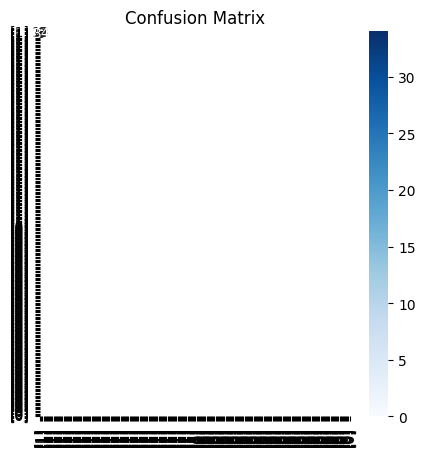

In [ ]:
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)

y_pred_tensor = tf.convert_to_tensor(y_pred_binary)
y_test_tensor = tf.convert_to_tensor(y_test)

cm = confusion_matrix(y_test_tensor, y_pred_tensor)
cm = pd.DataFrame(cm)

plt.figure(figsize = (5,5))
plt.title('Confusion Matrix')
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

plt.show()